#Dissipative Driven Entanglement Notebook
Author: Eugene Dumitrescu

In this notebook we (loosely) follow the prescription of Refs[1,2] to simulate the dynamical entanglement of QD systems coupled to a quantum environment. The approach taken is based on cavity QED, however our aim is to replace the cavity with a plasmonic reservoir.

### References
* [M. Otten, R. A. Shah, N. F. Scherer, M. Min, M. Pelton, and S. K. Gray, Phys. Rev. B 92, 125432 (2015)](http://journals.aps.org/prb/abstract/10.1103/PhysRevB.92.125432)
* [Dissipation-driven entanglement between qubits mediated by plasmonic nanoantennas](http://journals.aps.org/prb/abstract/10.1103/PhysRevB.89.235413)


# Entanglement in the dark

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from qutip import *

# operators acting on the composite spin-boson Hilbert space
def I(N,M):
    """Identity"""
    oplist = [qeye(2)] * N
    oplist.append(qeye(M))
    return tensor(oplist)

# spin operators
def sx(i, N, M):
    """Pauli X on qb i"""
    oplist = [qeye(2)] * N
    oplist[i] = sigmax()
    oplist.append(qeye(M))
    return tensor(oplist)

def sy(i, N, M):
    """Pauli Y on qb i"""
    oplist = [qeye(2)] * N
    oplist[i] = sigmay()
    oplist.append(qeye(M))
    return tensor(oplist)

def sz(i, N, M):
    """Pauli Z on qb i"""
    oplist = [qeye(2)] * N
    oplist[i] = sigmaz()
    oplist.append(qeye(M))
    return tensor(oplist)

def sm(i, N, M):
    """destroy quanta on qb i"""
    oplist = [qeye(2)] * N
    oplist[i] = sigmam()
    oplist.append(qeye(M))
    return tensor(oplist)

def sp(i, N, M):
    """create quanta on qb i"""
    oplist = [qeye(2)] * N
    oplist[i] = sigmap()
    oplist.append(qeye(M))
    return tensor(oplist)

def d(i,N,M):
    """dipole operator for ith spin"""
    return sp(i, N, M) + sm(i, N, M)

# plasmon / EM mode operators
def a(N, M):
    """bosonic annihiliation operator"""
    oplist = [qeye(2)] * N
    oplist.append(destroy(M))
    return tensor(oplist)

def n_a(N,M):
    """bosonic number operator"""
    return a(N,M).dag() * a(N,M)

def d_a(N,M):
    """bosonic dipole operator"""
    return a(N,M).dag() + a(N,M)

# spin subspace projection operators 
def P_S(N,M):
    """Symmetric |s = 1, m_l = 0> subspace projector"""
    return .25 * (I(N,M) - sz(0,N,M) * sz(1,N,M) + sx(0,N,M) * sx(1,N,M) + sy(0,N,M) * sy(1,N,M))

def P_A(N,M):
    """Anti-symmetric |s = 0, m_l = 0> subspace projector"""
    return .25 * (I(N,M) - sz(0,N,M) * sz(1,N,M) - sx(0,N,M) * sx(1,N,M) - sy(0,N,M) * sy(1,N,M))

def P_pp(N,M):
    """|++> subspace projector """
    return np.prod([sp(i,N,M) * sm(i,N,M)  for i in range(N)])

def P_mm(N,M):
    """|--> subspace projector """
    return np.prod([sm(i,N,M) * sp(i,N,M)  for i in range(N)])


## Hamiltonian and Model

Our model Hamiltonian for a N two levels systems (TLS) interacting with a bosonic reservoir is 
<center> $H = H_0 + H_{int} + H_{drv}$ </center>
where the individual, interacting, and driving components of the Hamiltonian are given by 
<center>
$\displaystyle H_0 = - \omega_0 \sum_{i=1}^N \sigma_z^{(i)} + \omega_c a^\dagger a$
</center>
<center>
$\displaystyle H_{int} = - \sum_{i}^N g_i (\sigma^{+}a + \sigma^{-}a^\dagger)$
</center>
<center>
$\displaystyle H_{drv} = - \sum_{i}^N \Omega_i \hat{d}_i + \Omega_a \hat{d}_a$
</center>
We have used the EM field and TLS dipole operators $\hat{d}_i = \sigma^+_{(i)}+\sigma^-_{(i)}$ and $\hat{d}_a = a + a^\dagger$  in the driving term and we have also applied the rotating wave approximation.

In [2]:
N = 2          # Number of spin 1/2's
M = 3          # Number of cavity modes
lam = 1        # constant that all other constants are given in terms of

# [0.0051, 0.0969, 0.0]
ws = [0.020, -0.020, 0.0]    # frequency/level spacing of each individual system
gs = [0.1, 0.1]              # position dependent couplings
ds = [0.1, 0.1, 0]           # driving strengths qb0,1, bosons 

def Ham(ws,gs,ds):
    """ Define the Hamiltonian as a function of the above parameters """
    H_0   = sum(ws[i] * sp(i,N,M) * sm(i,N,M) for i in range(N)) + ws[N] * n_a(N,M)
    H_RWA = sum(gs[i] * (a(N,M) * sp(i,N,M) + a(N,M).dag() * sm(i,N,M)) for i in range(N))
    H_DRV = sum(ds[i] * d(i,N,M) for i in range(N)) + ds[N] * d_a(N,M)
    return H_0 - H_RWA - H_DRV

# Lindblad dissipation parameters
kap   = 1 * lam           # cavity relaxation rate
gam   = 1 * kap/1e8   # atom relaxation rate
gdph  = 0 * kap/1e6       # atom dephasing rate 
n_th  = 0.0               # thermal cavity occupation number 

def cops(kappa, gamma, deph, n_th):
    """
    Define collapse operators for Lindblad master equation
    
    Parameters
    ----------
    kappa: cavity relaxation rate,  ~ 500 THz ~ 2 eV
    gamma: emitter relaxation rate, ~ 10 MHz ~ 1mueV
    gdph: emitter dephasing rate,   ~ same as relaxation rate
    n_th: temperature for entire system, gives excitation rate

    Returns
    -------
    c_ops: list of collapse operators
    """
    c_ops = []
    for i in range(2):
        rate = np.sqrt(gamma * (1 + n_th))
        if rate > 0.0:
            c_ops.append(rate * sm(i,N,M))        # relaxation
        rate = gamma * n_th
        if rate > 0.0:
            c_ops.append(rate * sm(i,N,M).dag())  # excitation
        c_ops.append(np.sqrt(deph) * sz(i,N,M))   # dephasing  
    rate = np.sqrt(kappa * (n_th + 1))
    if rate > 0: 
        c_ops.append(rate * a(N,M))
    rate = np.sqrt(kappa * (n_th))
    if rate > 0: 
        c_ops.append(rate * a(N,M).dag())
    return c_ops

# Dynamical Evolution

Let us initialize system with one dot excited and the other in the ground state and allow the system to evolve dissipatively. Short lived entanglement, as measured by the concurrence, should be generated between the dots; although asymmetric couplings may be needed to realize the expected result. 


## Master Eqaution:

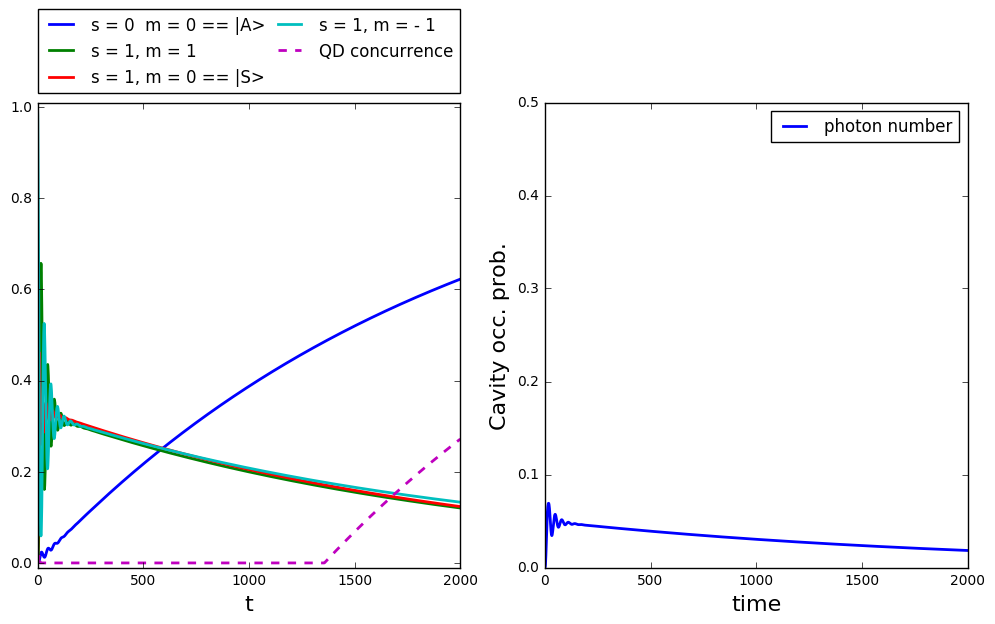

In [3]:
# Initial state
psi_0 = basis(2,1)                   # qb 1  ground state
psi_1 = basis(2,1)                   # qb 2 excited state
psi_c = basis(M,0)                   # initial fock state
psi_tot = tensor(psi_0,psi_1,psi_c)  # tensor product

# discretized time domain
tlist = np.linspace(0,2e3, 2e3)

# run dynamics solver
result = mesolve(Ham(ws,gs,ds), psi_tot, tlist, cops(kap, gam, gdph, n_th), [])

# expectation value operators: subspace occupation number projectors and concurrence
e_ops = [P_S(N,M), P_A(N,M), P_pp(N,M), P_mm(N,M), n_a(N,M)]
Ex_P_S, Ex_P_A, Ex_Ppp, Ex_Pmm, Ex_n_a = [[expect(e,st) for st in result.states] for e in e_ops]
concr = [concurrence(ptrace(st,(0,1))) for st in result.states]

#plot results
fig, axes = plt.subplots(1, 2, figsize=(12,6))

times = tlist      # renormakize time units
axes[0].plot(times, Ex_P_A, '-', linewidth=2, label="s = 0  m = 0 == |A>")
axes[0].plot(times, Ex_Ppp, '-', linewidth=2, label="s = 1, m = 1")
axes[0].plot(times, Ex_P_S, '-', linewidth=2, label="s = 1, m = 0 == |S>")
axes[0].plot(times, Ex_Pmm, '-', linewidth=2, label="s = 1, m = - 1")
axes[0].plot(times, concr , '--', linewidth=2, label="QD concurrence")
axes[0].set_ylim(-.01,1.01)
axes[0].set_xlabel("t", fontsize=16)
axes[0].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)

axes[1].plot(times, Ex_n_a, '-', linewidth=2, label="photon number")
axes[1].set_ylim(0, .5)
axes[1].set_ylabel("Cavity occ. prob.", fontsize=16)
axes[1].set_xlabel("time", fontsize=16)
axes[1].legend(loc=0)
# np.transpose([Ex_P_A, Ex_Ppp, Ex_P_S, Ex_Pmm])  # plotted data
plt.show()

# Correlations

We proposed to optically characterize the entanglement generated in our device by means of the normalized second order coherence function:

<center>
$\displaystyle g^2(r_1,t_1;r_2,t_2) = \frac{\langle a^\dagger (r_1,t_1) a^\dagger (r_2,t_2) a(r_2,t_2) a(r_1,t_1) \rangle}{\langle a^\dagger(r_1,t_1) a(r_1,t_1) \rangle \langle a^\dagger(r_2,t_2) a(r_2,t_2) \rangle}$
</center>

Suppose we probe light from the same spatio-temporal source (i.e. a stationary process with $r_1=r_2$) and introduce a time delay denoted by $\tau = t_2 - t_1$. In this case $g^2$ does not depend on $t_1$ and $t_1$ but only on their difference $\tau$. We can then express the second order coherence function in the following form:

<center>
$\displaystyle g^2(t, \tau) = \frac{\langle a^\dagger (t) a^\dagger (t + \tau) a(t + \tau) a(t) \rangle}{\langle a^\dagger(t) a(t) \rangle^2}$
</center>

Below we show 2 coherence functions. In the first $t$ is set to $0$ such that $g^2(0,\tau)\equiv g^2(\tau)$ and correlations are therefore calculated with respect to the initial (Fock state) of the cavity. One may also calculate the correlation function in the limit $t \rightarrow \infty$ such that the correlations are calculated with respect to the steady state solution (provided such a solution exists).


# Numerical Solution

In order to calculate the second order correlation function we follow the following procedure

- Take the steady state $\rho_{ss}$ and simulate an emission event by destroying a single quanta of energy 
    - Note this could technically occur in either of the emitters *or* in the plasmonic cavity. For now we assume the emitters are responsible for the spontaneous emission. 
- Evolve the system in time and renormalize by the steady state $g^2$ denominator
    


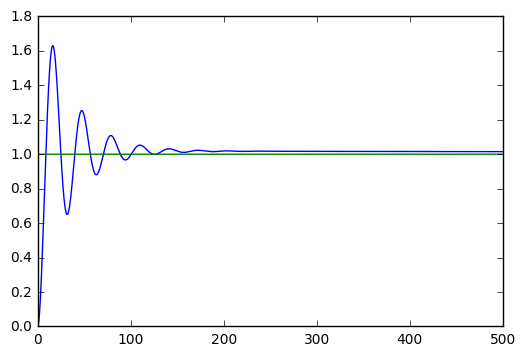

In [9]:
# expectation value for QD occupation number
e_ss_ops = sp(0,N,M) * sm(0,N,M)

# discretized g2 time domain
taus = np.linspace(0,5e2, 2e3)

# density matrices before emission (steady state) and after emission (ae)
rho_ss = steadystate(Ham(ws, gs, ds), cops(kap, gam, gdph, n_th))
rho_ae = sm(0,N,M) * rho_ss * sp(0,N,M)
rho_ae = rho_ae/rho_ae.tr()
denom = np.real((e_ss_ops * rho_ss).tr())   # g2 denominator for steady state


# solve for <sp*sm> with respect to the post emission state
results = mesolve(Ham(ws, gs, ds), rho_ae, taus, cops(kap, gam, gdph, n_th), e_ss_ops)
g2 = results.expect[0]/denom


one = [1] * len(taus)
plt.plot(taus, g2)
plt.plot(taus, one)
plt.show()

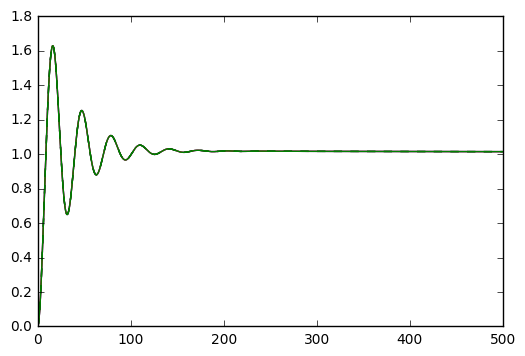

In [8]:
# expectation value for QD occupation number
e_ss_ops = [sp(0,N,M) * sm(0,N,M), sp(1,N,M) * sm(1,N,M)]

# discretized g2 time domain
taus = np.linspace(0,5e2, 2e3)

# density matrices before emission (steady state) and after emission (ae)
rho_ss = steadystate(Ham(ws, gs, ds), cops(kap, gam, gdph, n_th))
rho_ae = [sm(0,N,M) * rho_ss * sp(0,N,M), sm(1,N,M) * rho_ss * sp(1,N,M)] 
rho_ae = [r/r.tr() for r in rho_ae]

# solve for <sp*sm> with respect to the post emission state
results = [mesolve(Ham(ws, gs, ds), r, taus, cops(kap, gam, gdph, n_th), e_ss_ops) for r in rho_ae]

# steady state g2 denominator/normalization constants
denoms = [np.real((e * rho_ss).tr()) for e in e_ss_ops]  

plt.plot(taus, results[0].expect[0]/np.sqrt(denoms[0]*denoms[0]),'b')
plt.plot(taus, results[0].expect[1]/np.sqrt(denoms[1]*denoms[1]),'r')
plt.plot(taus, results[1].expect[0]/np.sqrt(denoms[0]*denoms[0]),'k--')
plt.plot(taus, results[1].expect[1]/np.sqrt(denoms[1]*denoms[1]),'g')
# plt.plot(taus, one, 'c')
g2 = sum(results[i].expect[j]/np.sqrt(denoms[j]*denoms[j])/4 for i in range(2) for j in range(2))
plt.plot(taus, g2, 'g--')
plt.show()


## $g^2(\tau)$ dependence on concurrence and other parameters

- First on the emitter detuning $\omega_1$
- emitter driving strength/ dipole moment $d_1$
- plasmon dipole moment $d_P$

Results are that 

AttributeError: 'numpy.ndarray' object has no attribute 'set_xlabel'

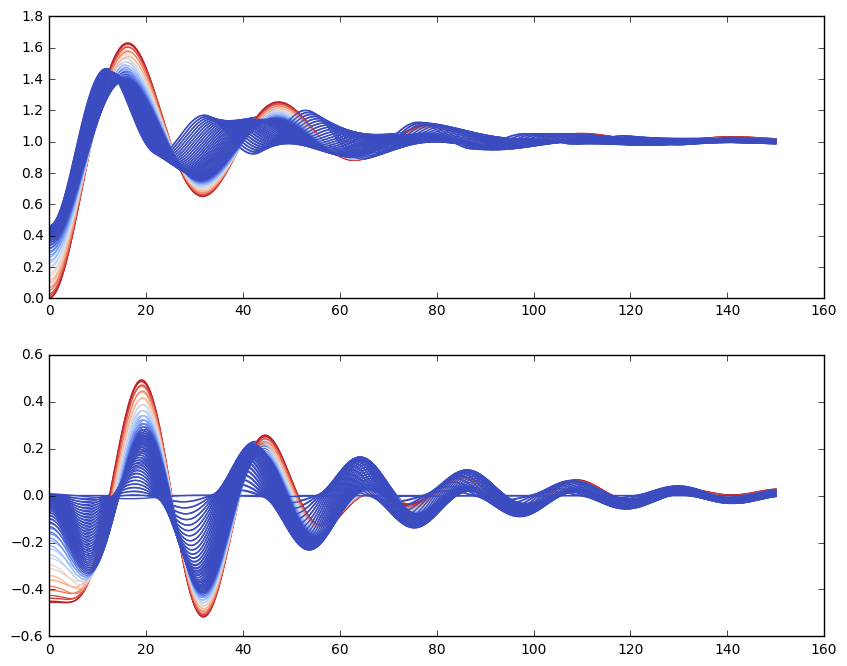

In [5]:
# expectation value for QD occupation number
e_ss_ops = [sp(0,N,M) * sm(0,N,M), sp(1,N,M) * sm(1,N,M)]

# discretized g2 time domain
taus = np.linspace(0,1.5e2, 2e3)

# parameter range
num = 75
w_range = np.linspace(-.2, 0.2, num)
wss = [[0.02, w, 0.0] for w in w_range]
g2s = [0] * num
cnc = [0] * num

for i in range(num):
    # density matrices before emission (steady state) and after emission (ae)
    rho_ss = steadystate(Ham(wss[i], gs, ds), cops(kap, gam, gdph, n_th))
    rho_ae = [sm(0,N,M) * rho_ss * sp(0,N,M), sm(1,N,M) * rho_ss * sp(1,N,M)] 
    rho_ae = [r/r.tr() for r in rho_ae]
    cnc[i] = concurrence(ptrace(rho_ss,[0,1]))   # steady state concurrence
    
    # solve for <sp*sm> with respect to the post emission state
    results = [mesolve(Ham(wss[i], gs, ds), r, taus, cops(kap, gam, gdph, n_th), e_ss_ops) for r in rho_ae]

    # steady state g2 denominator/normalization constants
    denoms = [np.real((e * rho_ss).tr()) for e in e_ss_ops]  
    g2s[i] = sum(results[i].expect[j]/np.sqrt(denoms[j]*denoms[j])/4 for i in range(2) for j in range(2))

    
fig, ax = plt.subplots(2, figsize=(10, 8))
for i in range(num):
    ax[0].plot(taus, g2s[i], color=plt.cm.coolwarm(cnc[i]))
    ax[1].plot(taus, g2s[i]- g2s[0], color=plt.cm.coolwarm(cnc[i]))
mpbl = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=min(cnc), vmax=max(cnc)))
mpbl._A = []  # fake up the array of the scalar mappable
ax.set_xlabel('$\\tau$')
ax.set_ylabel('$g^{(2)}(\\tau)$')
plt.colorbar(mpbl)
plt.savefig("g2_detuning.pdf")
plt.show()

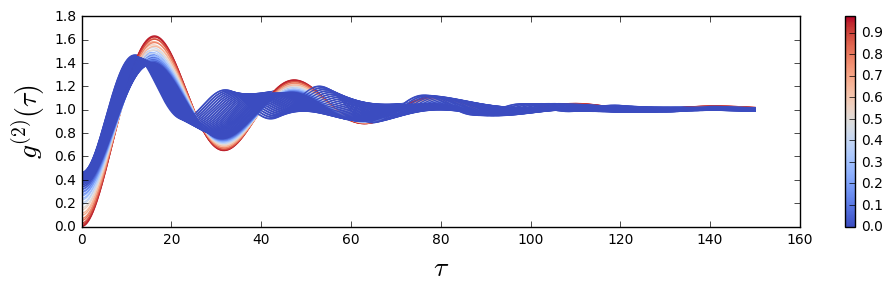

In [12]:
fig, ax = plt.subplots(1, figsize=(10, 3))
ax.set_xlabel('$\\tau$', fontsize=20)
ax.set_ylabel('$g^{(2)}(\\tau)$', fontsize=20)
plt.colorbar(mpbl)

for i in range(num):
    ax.plot(taus, g2s[i], color=plt.cm.coolwarm(cnc[i]))
#     ax[1].plot(taus, g2s[i]- g2s[0], color=pl t.cm.coolwarm(cnc[i]))
mpbl = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=min(cnc), vmax=max(cnc)))
mpbl._A = []  # fake up the array of the scalar mappable
plt.tight_layout()
plt.savefig("g2_detuning.pdf")
plt.show()

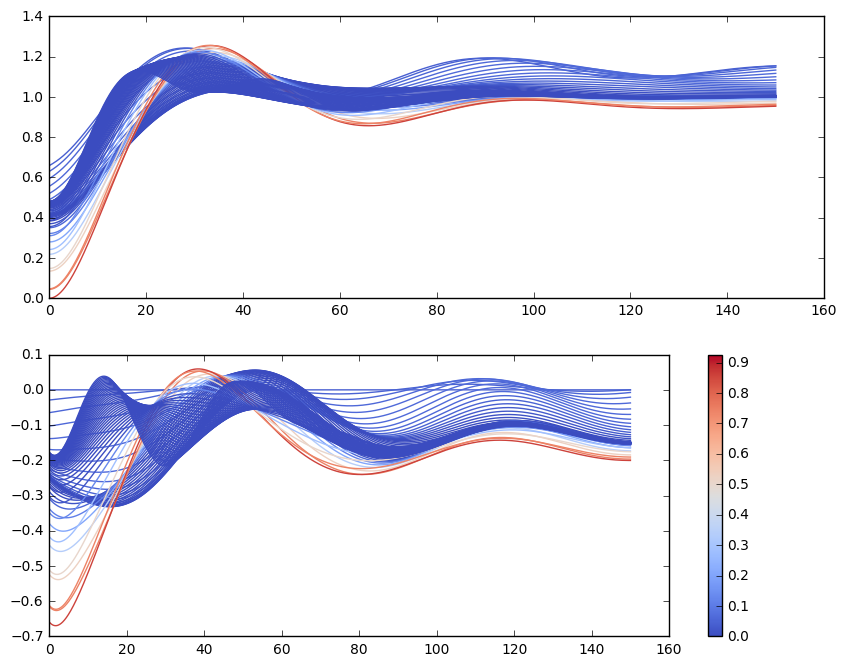

In [50]:
# expectation value for QD occupation number
e_ss_ops = [sp(0,N,M) * sm(0,N,M), sp(1,N,M) * sm(1,N,M)]

# discretized g2 time domain
taus = np.linspace(0,1.5e2, 2e3)

# parameter range
num = 75
d_range = np.linspace(0, 0.1, num)
dss = [[0.05, d, 0] for d in d_range]
g2s = [0] * num
cnc = [0] * num

for i in range(num):
    # density matrices before emission (steady state) and after emission (ae)
    rho_ss = steadystate(Ham(ws, gs, dss[i]), cops(kap, gam, gdph, n_th))
    rho_ae = [sm(0,N,M) * rho_ss * sp(0,N,M), sm(1,N,M) * rho_ss * sp(1,N,M)] 
    rho_ae = [r/r.tr() for r in rho_ae]
    cnc[i] = concurrence(ptrace(rho_ss,[0,1]))   # steady state concurrence
    
    # solve for <sp*sm> with respect to the post emission state
    results = [mesolve(Ham(ws, gs, dss[i]), r, taus, cops(kap, gam, gdph, n_th), e_ss_ops) for r in rho_ae]

    # steady state g2 denominator/normalization constants
    denoms = [np.real((e * rho_ss).tr()) for e in e_ss_ops]  
    g2s[i] = sum(results[k].expect[j]/np.sqrt(denoms[k]*denoms[j])/4 for k in range(2) for j in range(2))

    
fig, ax = plt.subplots(2, figsize=(10, 8))
for i in range(num):
    ax[0].plot(taus, g2s[i], color=plt.cm.coolwarm(cnc[i]))
    ax[1].plot(taus, g2s[i]- g2s[0], color=plt.cm.coolwarm(cnc[i]))
mpbl = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=min(cnc), vmax=max(cnc)))
mpbl._A = []  # fake up the array of the scalar mappable
plt.colorbar(mpbl)
plt.savefig("g2_driving.pdf")
plt.show()

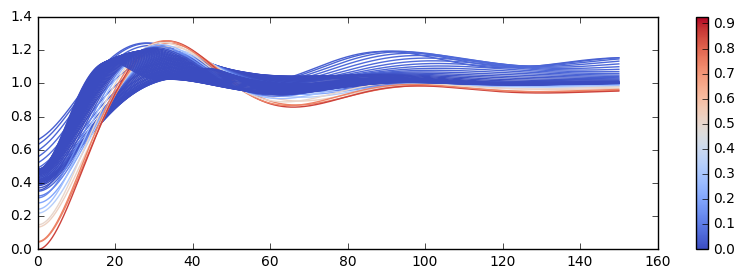

In [51]:
fig, ax = plt.subplots(1, figsize=(10, 3))
for i in range(num):
    ax.plot(taus, g2s[i], color=plt.cm.coolwarm(cnc[i]))
#     ax[1].plot(taus, g2s[i]- g2s[0], color=pl t.cm.coolwarm(cnc[i]))
mpbl = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=min(cnc), vmax=max(cnc)))
mpbl._A = []  # fake up the array of the scalar mappable
plt.colorbar(mpbl)
plt.savefig("g2_driving.pdf")
plt.show()

# # this is an inset axes over the main axes
# a = plt.axes([.65, .6, .2, .2], facecolor='y')
# n, bins, patches = plt.hist(s, 400, normed=1)
# plt.title('Probability')
# plt.xticks([])
# plt.yticks([])


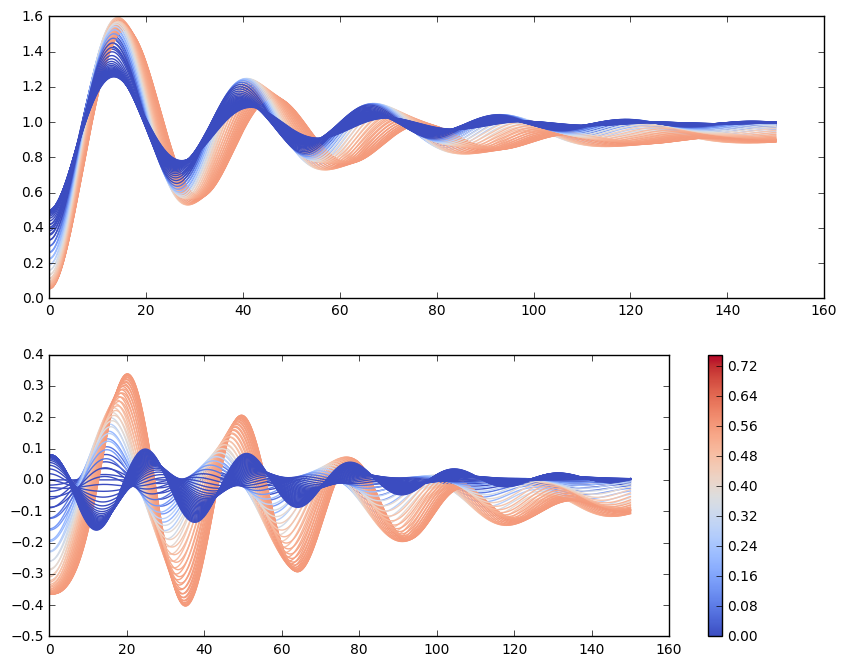

In [195]:
# expectation value for QD occupation number
e_ss_ops = [sp(0,N,M) * sm(0,N,M), sp(1,N,M) * sm(1,N,M)]

# discretized g2 time domain
taus = np.linspace(0,1.5e2, 2e3)

# parameter range
num = 75
d_range = np.linspace(-.5, 1, num)
dss = [[-0.101, -0.0888, d] for d in d_range]
g2s = [0] * num
cnc = [0] * num

for i in range(num):
    # density matrices before emission (steady state) and after emission (ae)
    rho_ss = steadystate(Ham(ws, gs, dss[i]), cops(kap, gam, gdph, n_th))
    rho_ae = [sm(0,N,M) * rho_ss * sp(0,N,M), sm(1,N,M) * rho_ss * sp(1,N,M)] 
    rho_ae = [r/r.tr() for r in rho_ae]
    cnc[i] = concurrence(ptrace(rho_ss,[0,1]))   # steady state concurrence
    
    # solve for <sp*sm> with respect to the post emission state
    results = [mesolve(Ham(ws, gs, dss[i]), r, taus, cops(kap, gam, gdph, n_th), e_ss_ops) for r in rho_ae]

    # steady state g2 denominator/normalization constants
    denoms = [np.real((e * rho_ss).tr()) for e in e_ss_ops]  
    g2s[i] = sum(results[i].expect[j]/np.sqrt(denoms[j]*denoms[j])/4 for i in range(2) for j in range(2))

    
fig, ax = plt.subplots(2, figsize=(10, 8))
for i in range(num):
    ax[0].plot(taus, g2s[i], color=plt.cm.coolwarm(cnc[i]))
    ax[1].plot(taus, g2s[i]- g2s[0], color=plt.cm.coolwarm(cnc[i]))
mpbl = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=min(cnc), vmax=max(cnc)))
mpbl._A = []  # fake up the array of the scalar mappable
plt.colorbar(mpbl)
plt.savefig("g2_coupling.pdf")
plt.show()